# **Pre Classification Analysis** 

In [4]:
import sys
sys.path
sys.path.append('/home/jovyan/data_preprocessing')

### Set file paths

In [5]:
file_comments = "../../data/raw_data/Askpolitics_comments.zst"
file_submissions = "../../data/raw_data/Askpolitics_submissions.zst"

subreddit_here = "Askpolitics"
subreddit = "Askpolitics"


output_path = f"../../data/new_preprocessing/{subreddit_here}_new_preprocessing_com_rep.csv"



In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import seaborn as sns

import zstandard
import io

from sklearn.model_selection import train_test_split
from scipy import sparse
import random
from itertools import combinations
import collections
import multiprocessing
import copy
import time

pd.options.mode.chained_assignment = None

In [7]:
from preprocessing_functions import import_subreddit
from preprocessing_functions import aggregate_interactions_directed
from preprocessing_functions import get_counts_and_shares
from preprocessing_functions import find_max
from preprocessing_functions import build_undirected
from preprocessing_functions import get_submissions
from preprocessing_functions import get_comments_and_replies
from preprocessing_functions import assign_types
from preprocessing_functions import find_relevant_submissions
from preprocessing_functions import plot_submissions_comments
from preprocessing_functions import match_reply_comment_submission
from preprocessing_functions import preprocess_texts
from preprocessing_functions import import_merge_predicted_labels

***

## **Data Import**

In [8]:
# import data
data_comments = import_subreddit(file_comments)
data_submissions = import_subreddit(file_submissions)


In [9]:
# make df
df_comments = pd.DataFrame(data_comments)
df_submissions = pd.DataFrame(data_submissions)

In [10]:
# submissions
# filter relevant columns

submissions = get_submissions(df_submissions)

Nr. of pulled submissions 9508


In [11]:
# comments
# select relevant columns only

df_comments_replies = get_comments_and_replies(df_comments)

Nr. of pulled comments & replies 78714


In [12]:
# assign types and extract them to separate dfs
comments, replies = assign_types(df_comments_replies, submissions)

Nr. of comments 29147
Nr. of replies 14192


### Filter relevant submissions

* relevant_comments: those with a parent, that is in relevant_submissions

In [13]:
relevant_submissions = pd.DataFrame(comments.groupby('parent_id')['id'].count()).reset_index().rename(columns={'parent_id' : 'submission_id', 'id' : 'count'})
print(relevant_submissions['count'].mean())
relevant_submissions

# get nr of submissions, for which I do have comments --> 29.304

3.548885912577621


,submission_id,count
0,100a6qb,2
1,100g7ul,6
2,100z6pn,4
3,1010brb,5
4,101x3jw,1
...,...,...
8208,zycuup,1
8209,zyi1ad,2
8210,zz8wgk,2
8211,zzg506,2


In [15]:
plt_data = pd.DataFrame(relevant_submissions['count'].value_counts()).rename(columns={'count' : 'class_count'}).reset_index().rename(columns={'count' : 'comment_count'}).sort_values(by = "comment_count").reset_index(drop=True)

plt_data['log_com_count'] = plt_data['comment_count'].apply(lambda x: np.log10(x))
plt_data['log_class_count'] = plt_data['class_count'].apply(lambda x: np.log10(x))
plt_data

,comment_count,class_count,log_com_count,log_class_count
0,1,1793,0.000000,3.253580
1,2,1772,0.301030,3.248464
2,3,1344,0.477121,3.128399
3,4,1045,0.602060,3.019116
4,5,750,0.698970,2.875061
5,6,507,0.778151,2.705008
6,7,358,0.845098,2.553883
7,8,231,0.903090,2.363612
8,9,151,0.954243,2.178977
9,10,99,1.000000,1.995635


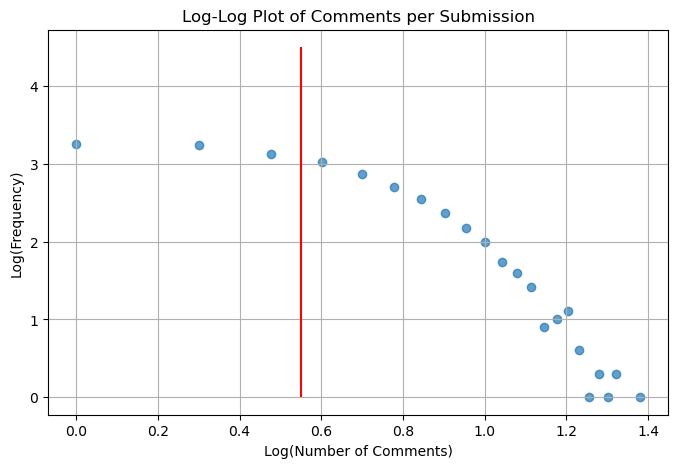

In [16]:
plt.figure(figsize=(8, 5))
plt.scatter(plt_data['log_com_count'], plt_data['log_class_count'], alpha=0.7)
plt.vlines(np.log10(relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=4.5)

plt.xlabel("Log(Number of Comments)")
plt.ylabel("Log(Frequency)")
plt.title("Log-Log Plot of Comments per Submission")
plt.grid(True)
plt.show()

In [ ]:
# select relevant submissions 
relevant_submissions, relevant_comments, empty_submissions, empty_comments = find_relevant_submissions(df_comments = comments, df_submissions = submissions, submission_id_col = "parent_id", comment_id_col = "id")

Mean nr. of comments per submission 3.548885912577621
Nr. of submission, that I have comments for 8213
All submissions found
Removing empty submissions deleted 3297 submissions
Empty submissions in df_submissions_empty: 3297
Kept 4916 submissions
Nr. of comments, whose submission is retaied 17704
Share 0.6074038494527739
Nr. of comments, whose submission is empty 11443
Share 0.39259615054722613


In [20]:

print(f"Number of relevant submissions: {len(relevant_submissions)}")
print("Lost submissions: ", len(submissions) - len(relevant_submissions))

relevant_submissions

relevant_comments.reset_index(drop=True, inplace=True)
relevant_comments

# roughly half

Number of relevant submissions: 4916
Lost submissions:  4592


,author,created_utc,parent_id,subreddit_id,body,link_id,name,id,ups,score,downs,subreddit,likes,replies,stickied,send_replies,comment_type,date,type
0,[deleted],1.317888e+09,l2lpu,2s5s2,"The way I see it, the OWS protests boil down t...",l2lpu,c2pazap,c2pazap,1.0,1,0.0,Askpolitics,NaN,NaN,NaN,NaN,NaN,2011-10-06,comment
1,SteepleMeister,1.318995e+09,lh2ra,2s5s2,I would propose an amendment that would define...,lh2ra,c2smnv6,c2smnv6,2.0,2,0.0,Askpolitics,NaN,NaN,NaN,NaN,NaN,2011-10-19,comment
2,piper82,1.319037e+09,lh2ra,2s5s2,Outlawing abortion.,lh2ra,c2sq9e4,c2sq9e4,0.0,0,0.0,Askpolitics,NaN,NaN,NaN,NaN,NaN,2011-10-19,comment
3,ejduck3744,1.320030e+09,lh2ra,2s5s2,"bad idea, by them having to be re elected ever...",lh2ra,c2vrcut,c2vrcut,1.0,1,0.0,Askpolitics,NaN,NaN,NaN,NaN,NaN,2011-10-31,comment
4,[deleted],1.320472e+09,lh2ra,2s5s2,I think term limits would be more effective.,lh2ra,c2x88w3,c2x88w3,1.0,1,0.0,Askpolitics,NaN,NaN,NaN,NaN,NaN,2011-11-05,comment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17699,DaSaw,1.703990e+09,18un5u8,2s5s2,"At it's most basic, a lobbyist is someone whos...",18un5u8,kfn8fz9,kfn8fz9,1.0,1,0.0,Askpolitics,NaN,,False,True,NaN,2023-12-31,comment
17700,tnic73,1.704028e+09,18v6zv6,2s5s2,It depends on how you view the political spect...,18v6zv6,kfozima,kfozima,1.0,1,0.0,Askpolitics,NaN,,False,True,NaN,2023-12-31,comment
17701,apollo151,1.704029e+09,18v6zv6,2s5s2,Far-right insofar as the far-right in the poli...,18v6zv6,kfp0ros,kfp0ros,2.0,2,0.0,Askpolitics,NaN,,False,True,NaN,2023-12-31,comment
17702,W_AS-SA_W,1.704035e+09,18v6zv6,2s5s2,No that would be considered tyrannical or dict...,18v6zv6,kfpdcvz,kfpdcvz,1.0,1,0.0,Askpolitics,NaN,,False,True,NaN,2023-12-31,comment


### Build df
* Match first level replies to relevant comments to relevant submissions
* Join = 'inner', because only keep replies, that have a parent in the relevant_comments
    * Missings due to replies, that did not find a comment to belong to.
    * This happend, because comments were dropped, if they were a comment to a submission, that had too little comments (below average)
    * Between comments and submissions, there won't be missings, as relevant_submissions were used to filter relevant_comments 

In [21]:
df_matched, com_per_sub, rep_per_com = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'inner', subreddit_here)
df_matched

Nr. of unique replies 8757
Nr. of unique comments 7020
Nr. of unique submissions 3542
A submission receives on average 1.981931112365895 comments.
A comment receives on average 1.2474358974358974 replies.
Share of matched submissions: 0.7205044751830757


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c2smnv6,c2t7ii8,Perfect.,Askpolitics,1.319172e+09,[deleted],1.0,1,0.0,lh2ra,...,SteepleMeister,2.0,2,0.0,1.318995e+09,"I would prevent any Representative, Senator or...",Axemantitan,8.0,6,1.318994e+09
1,c3ajwsf,c3fdl7m,[deleted],Askpolitics,1.326106e+09,[deleted],1.0,1,0.0,nh0sx,...,iammolotov,1.0,1,0.0,1.324645e+09,Please enlighten me.,very_nice_how_much,5.0,4,1.324182e+09
2,c5jr1ep,c5jrgbt,Ah thank you. Great answer. I was writing a pa...,Askpolitics,1.343322e+09,[deleted],1.0,1,0.0,v8kj6,...,[deleted],2.0,2,0.0,1.343320e+09,I have been doing some research on whether par...,[deleted],1.0,1,1.340048e+09
3,c5jo72n,c5k2lfz,"A bigger issue than the political shift would,...",Askpolitics,1.343363e+09,haydensane,2.0,2,0.0,x6egl,...,meelar,3.0,3,0.0,1.343309e+09,Which states would be the most affected? How w...,InnocentAlternate,1.0,1,1.343284e+09
4,c5qzrah,c5r2091,I know I was looking more for more data based ...,Askpolitics,1.344609e+09,Sernando,1.0,1,0.0,xyno1,...,expectantyoke,2.0,2,0.0,1.344595e+09,http://imgur.com/Uiutt\nHow much of these are ...,Sernando,1.0,1,1.344549e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8752,kfaw4xm,kfawnew,It's a weak analogy from the right. But good t...,Askpolitics,1.703790e+09,NerdyKeith,1.0,1,0.0,18syt1v,...,roastbeeftacohat,3.0,3,0.0,1.703790e+09,I keep seeing it in many threads involving lef...,NerdyKeith,3.0,3,1.703783e+09
8753,kff8zac,kffuy1h,>He is not legible for office because of treas...,Askpolitics,1.703872e+09,tnic73,1.0,1,0.0,18tpoop,...,space0watch,2.0,2,0.0,1.703864e+09,if you do not know Project 2025 will do will b...,MatteaGunnar,2.0,2,1.703864e+09
8754,kff8zac,kfgaoss,Do you feel the same way about the opponents P...,Askpolitics,1.703878e+09,brendbil,1.0,1,0.0,18tpoop,...,space0watch,2.0,2,0.0,1.703864e+09,if you do not know Project 2025 will do will b...,MatteaGunnar,2.0,2,1.703864e+09
8755,kfl1jy0,kflitpm,"When you say ""extremists"" from a point of anyw...",Askpolitics,1.703966e+09,FJMMJ,1.0,1,0.0,18ukpy4,...,roastbeeftacohat,1.0,1,0.0,1.703960e+09,"He looks like a British gentleman, so why does...",cryptomelons,1.0,1,1.703957e+09


In [22]:
df_matched_empty, com_per_sub_empty, rep_per_com_empty = match_reply_comment_submission(replies, empty_comments, empty_submissions, 'inner', subreddit_here)
df_matched_empty


Nr. of unique replies 5300
Nr. of unique comments 4261
Nr. of unique submissions 2221
A submission receives on average 1.9185051778478164 comments.
A comment receives on average 1.243839474301807 replies.
Share of matched submissions: 0.6736427054898393


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c65qo76,c65qq7f,I feel that the sense of denial to me means th...,Askpolitics,1.347213e+09,Sentriculus,2.0,2,0.0,zlsh4,...,[deleted],2.0,2,0.0,1.347213e+09,,Sentriculus,3.0,3,1.347206e+09
1,c6deq14,c6det4f,"But *Mom*, it's an *election year*!",Askpolitics,1.348612e+09,[deleted],1.0,1,0.0,10h2bd,...,shamrock8421,2.0,2,0.0,1.348611e+09,,[deleted],1.0,1,1.348611e+09
2,c6foyh0,c6ftx8o,it sucks that this is true,Askpolitics,1.349063e+09,RowdyPants,1.0,1,0.0,10q8wc,...,JustinCayce,0.0,0,0.0,1.349042e+09,,Knuckleballerr,1.0,1,1.349042e+09
3,c6g0w3u,c6rymm4,Agreed. Anything from public broadcasting (PB...,Askpolitics,1.351232e+09,Dapples,1.0,1,0.0,10qulc,...,NopeNotConor,2.0,2,0.0,1.349109e+09,,Krywiggles,1.0,1,1.349064e+09
4,c7fq667,c7fw479,[deleted],Askpolitics,1.355396e+09,[deleted],1.0,1,0.0,10qulc,...,ManWithoutModem,1.0,1,0.0,1.355366e+09,,Krywiggles,1.0,1,1.349064e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5295,kdmntkb,kdnfsof,"It is a pretty complicated situation, not as b...",Askpolitics,1.702754e+09,FJMMJ,1.0,1,0.0,18juh5v,...,apollo151,2.0,2,0.0,1.702744e+09,,mental_capacityyay,2.0,2,1.702743e+09
5296,kdnewtw,kdopcw0,I would slightly disagree. I do think Russia w...,Askpolitics,1.702770e+09,Pjk125,1.0,1,0.0,18juh5v,...,tnic73,1.0,1,0.0,1.702754e+09,,mental_capacityyay,2.0,2,1.702743e+09
5297,ke6gmg9,ke94lhl,Do you favor repeal of section 3 of 14A?,Askpolitics,1.703117e+09,FrankTheRabbit28,1.0,1,0.0,18mo62q,...,tnic73,1.0,1,0.0,1.703080e+09,,PapaNicholsUSA,1.0,1,1.703054e+09
5298,ke6gmg9,kelykv2,You are aware that And Lincoln was elected sim...,Askpolitics,1.703341e+09,ki4jgt,1.0,1,0.0,18mo62q,...,tnic73,1.0,1,0.0,1.703080e+09,,PapaNicholsUSA,1.0,1,1.703054e+09


In [23]:

com_per_sub_empty = com_per_sub_empty.rename(columns={0 : 'nr_comments'})
rep_per_com_empty = rep_per_com_empty.rename(columns={0 : 'nr_replies'})

com_per_sub = com_per_sub.rename(columns={0 : 'nr_comments'})
rep_per_com = rep_per_com.rename(columns={0 : 'nr_replies'})


df_matched.to_csv(f"output/{subreddit_here}_df_matched.csv", index = False)
com_per_sub.to_csv(f"output/{subreddit_here}_com_per_sub.csv", index = False)
rep_per_com.to_csv(f"output/{subreddit_here}_rep_per_com.csv", index = False)

df_matched_empty.to_csv(f"output/{subreddit_here}_df_matched_empty.csv", index = False)
com_per_sub_empty.to_csv(f"output/{subreddit_here}_com_per_sub_empty.csv", index = False)
rep_per_com_empty.to_csv(f"output/{subreddit_here}_rep_per_com_empty.csv", index = False)

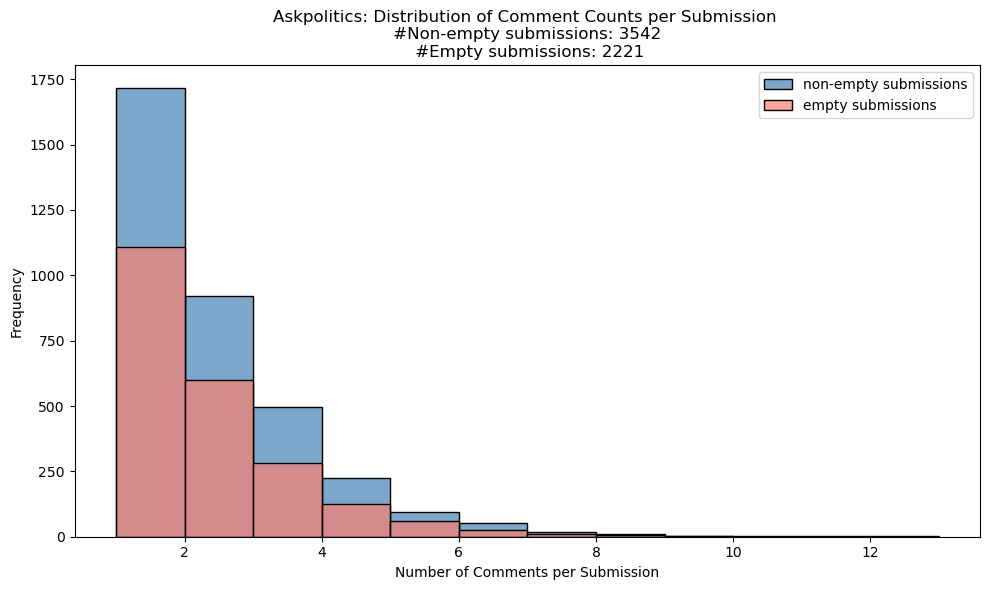

In [22]:

plt.figure(figsize=(10, 6))

sns.histplot(com_per_sub[0], binwidth=1, kde=False, label='non-empty submissions', color='steelblue', alpha=0.7)
sns.histplot(com_per_sub_empty[0], binwidth=1, kde=False, label='empty submissions', color='salmon', alpha=0.7)

plt.xlabel('Number of Comments per Submission')
#plt.xlim(0,60)
plt.ylabel('Frequency')
plt.title(f'{subreddit_here}: Distribution of Comment Counts per Submission \n #Non-empty submissions: {len(com_per_sub[0])} \n #Empty submissions: {len(com_per_sub_empty[0])}')
plt.legend()
plt.tight_layout()

plt.savefig(f"Hist_{subreddit_here}_Comment_per_Submission.pdf")
plt.show()

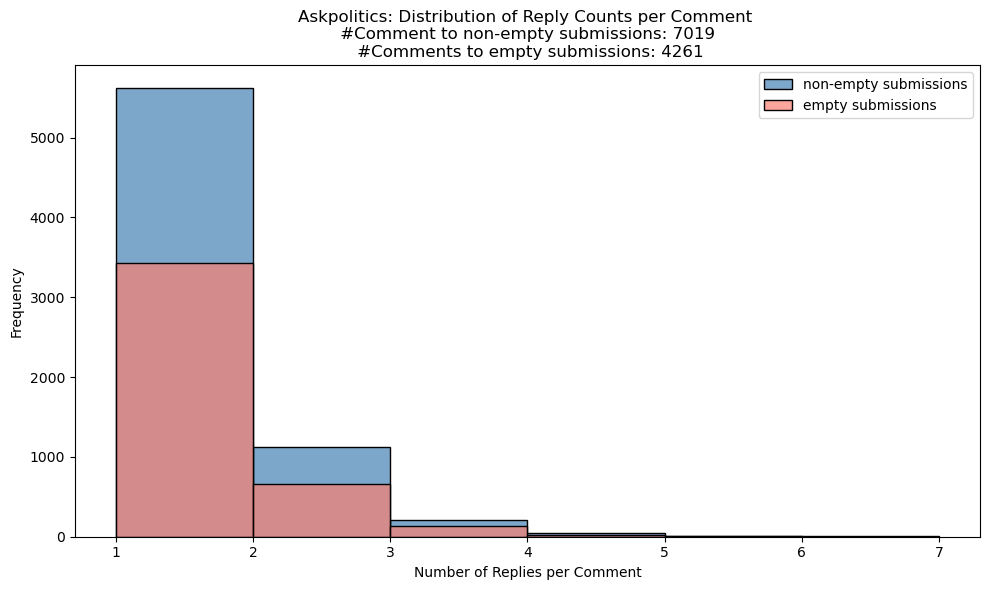

In [23]:

plt.figure(figsize=(10, 6))


sns.histplot(rep_per_com[0], binwidth=1, kde=False, label='non-empty submissions', color='steelblue', alpha=0.7)
sns.histplot(rep_per_com_empty[0], binwidth=1, kde=False, label='empty submissions', color='salmon', alpha=0.7)


plt.xlabel('Number of Replies per Comment')
#plt.xlim(0, 40)
plt.ylabel('Frequency')
plt.title(f'{subreddit_here}: Distribution of Reply Counts per Comment \n #Comment to non-empty submissions: {len(rep_per_com[0])} \n #Comments to empty submissions: {len(rep_per_com_empty[0])}')
plt.legend()
plt.tight_layout()

plt.savefig(f"Hist_{subreddit_here}_Replies_per_Comment.pdf")
plt.show()

C:\Users\3leso\AppData\Local\Temp\ipykernel_1428\1603355170.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])


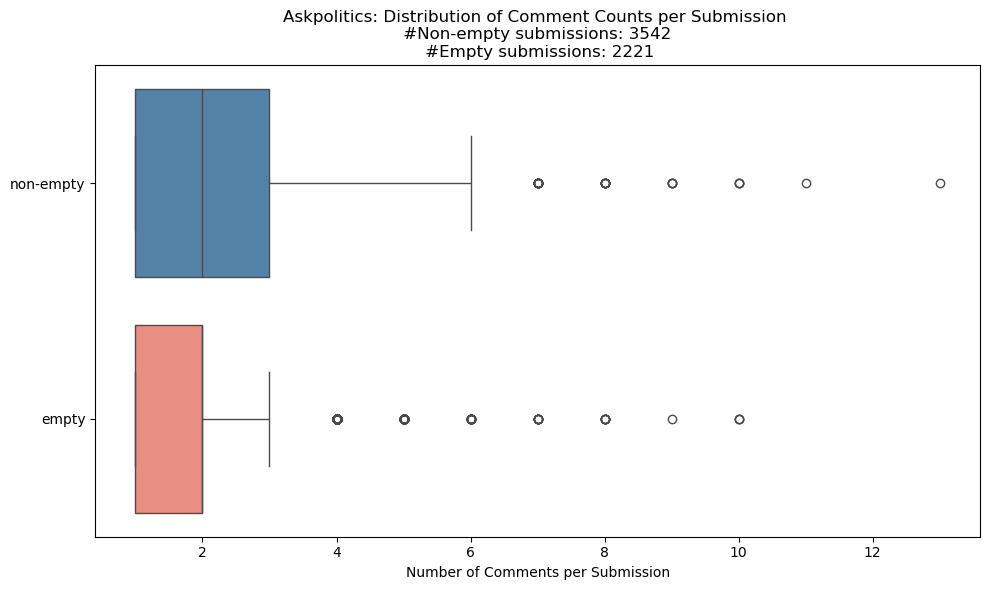

In [24]:
plt.figure(figsize=(10, 6))

df_box = pd.DataFrame({
    'comments': pd.concat([com_per_sub[0], com_per_sub_empty[0]], ignore_index=True),
    'type': ['non-empty'] * len(com_per_sub[0]) + ['empty'] * len(com_per_sub_empty[0])
})


# Create vertically stacked boxplots
sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])

plt.xlabel('Number of Comments per Submission')
plt.ylabel('')
#plt.xlim(0, 100)
plt.title(f'{subreddit_here}: Distribution of Comment Counts per Submission \n #Non-empty submissions: {len(com_per_sub[0])} \n #Empty submissions: {len(com_per_sub_empty[0])}')
plt.savefig(f"Box_{subreddit_here}_Comments_per_Submission.pdf")

plt.tight_layout()
plt.show()

C:\Users\3leso\AppData\Local\Temp\ipykernel_1428\3153005790.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])


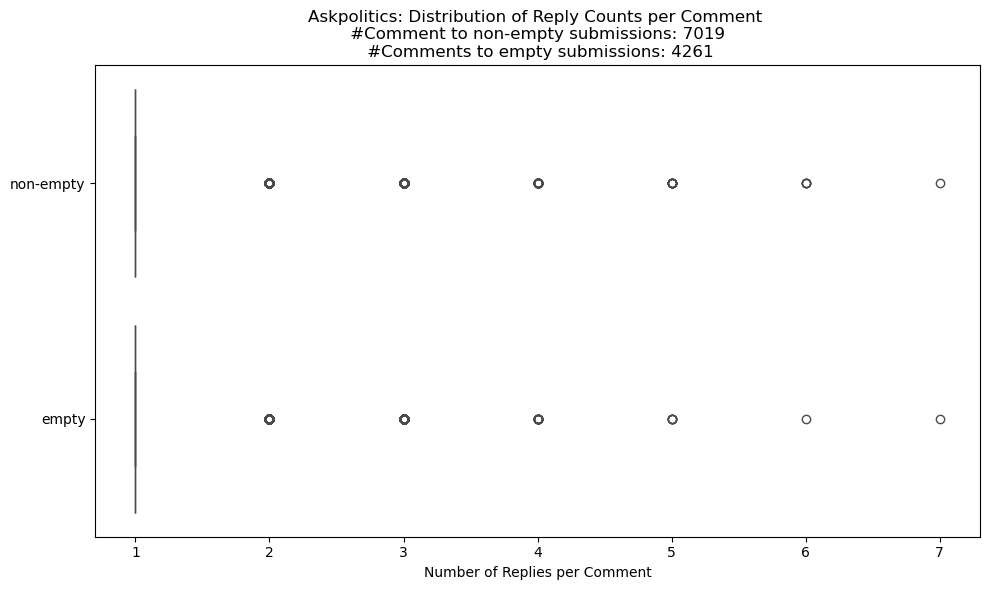

In [25]:
plt.figure(figsize=(10, 6))

df_box = pd.DataFrame({
    'comments': pd.concat([rep_per_com[0], rep_per_com_empty[0]], ignore_index=True),
    'type': ['non-empty'] * len(rep_per_com[0]) + ['empty'] * len(rep_per_com_empty[0])
})


# Create vertically stacked boxplots
sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])

plt.xlabel('Number of Replies per Comment')
plt.ylabel('')
#plt.xlim(0, 80)
plt.title(f'{subreddit_here}: Distribution of Reply Counts per Comment \n #Comment to non-empty submissions: {len(rep_per_com[0])} \n #Comments to empty submissions: {len(rep_per_com_empty[0])}')
plt.savefig(f"Box_{subreddit_here}_Replies_per_Comment.pdf")

plt.tight_layout()
plt.show()

In [22]:
duplicated = df_matched[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated

,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child



### Select High Quality Texts


* Filtering
    * remove deleted or removed parent and child texts (submissions no problem)
    * remove deleted authors of parents and childs (submissions no problem)
    * remove bodies (parents and childs) whose exact text occurred too often within the subreddit (i.e. bots)
    

* Preprocessing of texts
    * remove user mentions
    * remove subreddit mentions
    * remove URLs
    * remove line breaks
    * remove multiple spaces
    * replace &amp with and
    * (remove brackets and exclamation marks --> better not, they contain context)


* Filtering, second step
    * remove too short replies & comments (submissions no problem)


In [23]:
df_matched['body_child'].value_counts().head(10)

df_matched['body_parent'].value_counts().head(5)

#df[df['body_child'] == "Sorry, your post has been removed because your account does not currently meet the minimum required karma to post in this subreddit.\n\n\n*
# I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/AmericanPolitics) if you have any questions or concerns.*"]

# don't filter based on frequency of a text
# short replies (like thank you), will be removed with len < 5
# frequent comments can just be active comments
# bots are removed by author = [removed]


body_parent
[deleted]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [24]:
df = preprocess_texts(data = df_matched, length = 5)
df

Deleting all interactions with empty texts removed 713 interactions. Share:  0.08142057782345552
Kept 8044 interactions.
Deleting empty authors deleted 974 interactions. Share:  0.12108403779214322
Kept 7070 interactions.
Length 5 removes 701 interactions
Kept 6369 interactions
Drop duplicates (in parent & child text and author) removed 0 interactions. Share:  0.0
Kept 6369 interactions.
After text cleaning 6 interactions had empty texts and got removed. Share:  0.0009420631182289214
Kept 6363 interactions.


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c5jo72n,c5k2lfz,"A bigger issue than the political shift would,...",Askpolitics,1.343363e+09,haydensane,2.0,2,0.0,x6egl,...,meelar,3.0,3,0.0,1.343309e+09,Which states would be the most affected? How w...,InnocentAlternate,1.0,1,1.343284e+09
1,c5qzrah,c5r2091,I know I was looking more for more data based ...,Askpolitics,1.344609e+09,Sernando,1.0,1,0.0,xyno1,...,expectantyoke,2.0,2,0.0,1.344595e+09,How much of these are 'true' and to what exte...,Sernando,1.0,1,1.344549e+09
2,c5ybl4k,c5yc6u2,This is all similar stuff to what I've found. ...,Askpolitics,1.345854e+09,Sernando,1.0,1,0.0,xyno1,...,Ridonkulousley,2.0,2,0.0,1.345851e+09,How much of these are 'true' and to what exte...,Sernando,1.0,1,1.344549e+09
3,c66l1tj,c66l5jm,This is bullshit politics at it's finest and w...,Askpolitics,1.347371e+09,flyingbarmitzvah,1.0,1,0.0,zpguc,...,pearlhart,2.0,2,0.0,1.347371e+09,The basis of our support for Israel as far as ...,flyingbarmitzvah,3.0,3,1.347370e+09
4,c67a2lc,c68eogy,As a state employee do you think it will conti...,Askpolitics,1.347682e+09,Ridonkulousley,1.0,1,0.0,zs6jh,...,meelar,3.0,3,0.0,1.347484e+09,Just curious. Thanks for taking the time to re...,will_at_work,5.0,5,1.347480e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6358,kff8zac,kffuy1h,He is not legible for office because of treaso...,Askpolitics,1.703872e+09,tnic73,1.0,1,0.0,18tpoop,...,space0watch,2.0,2,0.0,1.703864e+09,if you do not know Project 2025 will do will b...,MatteaGunnar,2.0,2,1.703864e+09
6359,kff8zac,kfgaoss,Do you feel the same way about the opponents P...,Askpolitics,1.703878e+09,brendbil,1.0,1,0.0,18tpoop,...,space0watch,2.0,2,0.0,1.703864e+09,if you do not know Project 2025 will do will b...,MatteaGunnar,2.0,2,1.703864e+09
6360,kfh4tz5,kfh5y1s,All good points. But my question still stands....,Askpolitics,1.703890e+09,secondsniglet,1.0,1,0.0,18smc4h,...,matthedev,1.0,1,0.0,1.703889e+09,Why is there so much anticipation about how th...,secondsniglet,1.0,1,1.703742e+09
6361,kfl1jy0,kflitpm,When you say extremists from a point of anywhe...,Askpolitics,1.703966e+09,FJMMJ,1.0,1,0.0,18ukpy4,...,roastbeeftacohat,1.0,1,0.0,1.703960e+09,"He looks like a British gentleman, so why does...",cryptomelons,1.0,1,1.703957e+09


In [25]:
#df

duplicated = df[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated


,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


## **Check for Mods**

In [26]:
df['author_submission'].value_counts()[:20]

author_submission
DaveDragon11075         115
FaisalAli_91            115
TRIGGEREDharambe2018     71
AgentP-501_212           53
yeeto5o5                 35
kiwiheretic              35
lochnessthemonster       34
PinkPropaganda           33
TheFunkyBunny            32
javascript_dev           31
ShotsOfAutism            31
Passion_For_Learning     29
mikerichh                28
ThrowRA73000             26
ParticularGlass1821      25
ChibiDecker              25
Ok-Story-9319            23
Vexra                    21
SnugFnuggBlue            20
WeWannaKnow              20
Name: count, dtype: int64

In [27]:
df['author_parent'].value_counts()[:20]

author_parent
SovietRobot            156
brendbil               153
LabTech41              113
loselyconscious         97
Dammit_Banned_Again     79
limbodog                79
Ruar35                  78
Nadieestaaqui           76
VVillyD                 73
TrumpChooChooTrain      72
27SwingAndADrive        70
I_Need_Sources          66
robbini3                60
roastbeeftacohat        57
billiarddaddy           54
RowdyPants              54
cos                     53
writesgud               52
Sion_nois06             52
RedRemote45             52
Name: count, dtype: int64

In [28]:
df['author_child'].value_counts()[:20]

author_child
FaisalAli_91            91
loselyconscious         91
DaveDragon11075         89
brendbil                46
clocks_for_sale         45
RowdyPants              43
I_Need_Sources          43
SovietRobot             41
mikerichh               39
locri                   38
Quarter_Twenty          36
LabTech41               35
limbodog                35
DaSaw                   34
hrs922                  33
SexyDoorDasherDude      33
TRIGGEREDharambe2018    32
Dammit_Banned_Again     30
writesgud               28
PinkPropaganda          28
Name: count, dtype: int64

### Save and export

In [34]:
df.to_csv(output_path, index = False)
df = pd.read_csv(output_path)
df

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c5jo72n,c5k2lfz,"A bigger issue than the political shift would,...",Askpolitics,1.343363e+09,haydensane,2.0,2,0.0,x6egl,...,meelar,3.0,3,0.0,1.343309e+09,Which states would be the most affected? How w...,InnocentAlternate,1.0,1,1.343284e+09
1,c5qzrah,c5r2091,I know I was looking more for more data based ...,Askpolitics,1.344609e+09,Sernando,1.0,1,0.0,xyno1,...,expectantyoke,2.0,2,0.0,1.344595e+09,How much of these are 'true' and to what exte...,Sernando,1.0,1,1.344549e+09
2,c5ybl4k,c5yc6u2,This is all similar stuff to what I've found. ...,Askpolitics,1.345854e+09,Sernando,1.0,1,0.0,xyno1,...,Ridonkulousley,2.0,2,0.0,1.345851e+09,How much of these are 'true' and to what exte...,Sernando,1.0,1,1.344549e+09
3,c66l1tj,c66l5jm,This is bullshit politics at it's finest and w...,Askpolitics,1.347371e+09,flyingbarmitzvah,1.0,1,0.0,zpguc,...,pearlhart,2.0,2,0.0,1.347371e+09,The basis of our support for Israel as far as ...,flyingbarmitzvah,3.0,3,1.347370e+09
4,c67a2lc,c68eogy,As a state employee do you think it will conti...,Askpolitics,1.347682e+09,Ridonkulousley,1.0,1,0.0,zs6jh,...,meelar,3.0,3,0.0,1.347484e+09,Just curious. Thanks for taking the time to re...,will_at_work,5.0,5,1.347480e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6358,kff8zac,kffuy1h,He is not legible for office because of treaso...,Askpolitics,1.703872e+09,tnic73,1.0,1,0.0,18tpoop,...,space0watch,2.0,2,0.0,1.703864e+09,if you do not know Project 2025 will do will b...,MatteaGunnar,2.0,2,1.703864e+09
6359,kff8zac,kfgaoss,Do you feel the same way about the opponents P...,Askpolitics,1.703878e+09,brendbil,1.0,1,0.0,18tpoop,...,space0watch,2.0,2,0.0,1.703864e+09,if you do not know Project 2025 will do will b...,MatteaGunnar,2.0,2,1.703864e+09
6360,kfh4tz5,kfh5y1s,All good points. But my question still stands....,Askpolitics,1.703890e+09,secondsniglet,1.0,1,0.0,18smc4h,...,matthedev,1.0,1,0.0,1.703889e+09,Why is there so much anticipation about how th...,secondsniglet,1.0,1,1.703742e+09
6361,kfl1jy0,kflitpm,When you say extremists from a point of anywhe...,Askpolitics,1.703966e+09,FJMMJ,1.0,1,0.0,18ukpy4,...,roastbeeftacohat,1.0,1,0.0,1.703960e+09,"He looks like a British gentleman, so why does...",cryptomelons,1.0,1,1.703957e+09


***
## **Descriptive Stats**

In [35]:
# get nr of users

comm_auth = list(df_comments['author'].unique())
sub_auth = list(df_submissions['author'].unique())

authors = comm_auth + sub_auth
print(len(authors))
authors = set(authors)
authors.remove('[deleted]')
print("Unique Users: ", len(set(authors)))

10482
Unique Users:  7804


### Time Stats and originally pulled counts

In [ ]:
# Time frame
print("Time Frame \n---------------------------------------------")
print(f"Beginning of time frame: {df_comments_replies['date'].min()}")
print(f"End of time frame: {df_comments_replies['date'].max()}")
print("---------------------------------------------\n")

print("Number of Submissions, Comments and Replies \n---------------------------------------------")
print(f"Number of submissions: {len(submissions)}")
print(f"Number of comments and replies: {len(df_comments_replies)}")
print("---------------------------------------------\n")

Time Frame 
---------------------------------------------
Beginning of time frame: 2011-10-06
End of time frame: 2023-12-31
---------------------------------------------

Number of Submissions, Comments and Replies 
---------------------------------------------
Number of submissions: 9508
Number of comments and replies: 78714
---------------------------------------------



### Descriptive Stats after Matching

In [37]:
# Descriptive stats after matching

print("Number of unique replies: ", len(df_matched['msg_id_child'].unique()))
print("Number of unique comments: ", len(df_matched['msg_id_parent'].unique()))
print("Number of unique submissions: ", len(df_matched['submission_id'].unique()))

Number of unique replies:  8757
Number of unique comments:  7019
Number of unique submissions:  3542


### Descriptive Stats after cleaning for high quality texts

In [38]:
print("Unique Replies: ", len(df['msg_id_child'].unique()))
print("Unique Comments: ", len(df['msg_id_parent'].unique()))
print("Unique Submissions: ", len(df['submission_id'].unique()))

Unique Replies:  6363
Unique Comments:  5251
Unique Submissions:  2933


In [39]:
print("Unique Users: ", len(set(df['author_child']).union(df['author_parent'], df['author_submission'])))

Unique Users:  3382
